In [1]:
import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.95' # NOTE: jax preallocates GPU (default 75%)
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
from jax import numpy as jnp, random as jr, config as jconfig, devices as jdevices, jit, vmap, grad, debug, tree, lax, value_and_grad
jconfig.update("jax_enable_x64", True)
print(jdevices())

# from montecosmo.model import FieldLevelModel, default_config
# from montecosmo.utils import pdump, pload , Path
from pathlib import Path

%matplotlib inline
%load_ext autoreload
%autoreload 2
!hostname
#!jupyter nbconvert --to python /dvs_ro/u1/h/hsimfroy/workspace/montecosmo_proj/src/montecosmo/tests/infer_model2.ipynb

# save_dir = Path("./save/")
# save_dir = Path(os.path.expanduser("~/scratch/png/"))
# save_dir = Path("/lustre/fsn1/projects/rech/fvg/uvs19wt/png/") # JZ
# save_dir = Path("/lustre/fswork/projects/rech/fvg/uvs19wt/workspace/png/") # JZ
save_dir = Path("/pscratch/sd/h/hsimfroy/png/abacus_c0_i0_z08_lrg/test") # Perlmutter
load_dir = Path("/pscratch/sd/h/hsimfroy/png/abacus_c0_i0_z08_lrg/load/")
save_path = save_dir / "test"
save_dir.mkdir(parents=True, exist_ok=True)

[CudaDevice(id=0), CudaDevice(id=1), CudaDevice(id=2), CudaDevice(id=3)]
nid001064


/global/u1/h/hsimfroy/miniforge3/envs/montenv/lib/python3.13/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


## Import

In [2]:
import glob
cosmo, ic, z_obs, tracer = 0, 0, 0.8, 'LRG'
mesh_length, resampler = 576, 'ngp'

fn = {}
outdir = Path(os.getenv('SCRATCH')) / f'bias/{tracer}/z{z_obs:.3f}/AbacusSummit_base_c{cosmo:03d}_ph{ic:03d}/'
fn['catalog_tracer'] = f'/dvs_ro/cfs/cdirs/desi/cosmosim/SecondGenMocks/CubicBox/{tracer}/z{z_obs:.3f}/AbacusSummit_base_c{cosmo:03d}_ph{ic:03d}/LRG_real_space.fits'
fn['mesh_ic'] = f'/dvs_ro/cfs/cdirs/desi/public/cosmosim/AbacusSummit/ic/AbacusSummit_base_c{cosmo:03d}_ph{ic:03d}/ic_dens_N576.asdf'
fns = [glob.glob(f'/dvs_ro/cfs/cdirs/desi/public/cosmosim/AbacusSummit/AbacusSummit_base_c{cosmo:03d}_ph{ic:03d}/halos/z{z_obs:.3f}/{t}_rv_A/{t}_rv_A_*.asdf') for t in ['field', 'halo']]
fn['catalog_particle'] = sorted(sum(fns, []))
fns = fn

In [ ]:
# IC
def read_mesh(fn, z=None):
    fn = str(fn)
    import asdf
    with asdf.open(fn) as af:
        growth_table = 1.
        if z is not None:
            growth_table = af['header']['GrowthTable'][z]
        toret = jnp.array(af['data']['density']) * growth_table
    return toret
init_mesh = read_mesh(fns['mesh_ic'], z=0)
shape = init_mesh.shape
print(shape)
jnp.save(load_dir / f'init_mesh_{mesh_length}.npy', init_mesh)

/global/common/software/desi/users/adematti/perlmutter/cosmodesiconda/20250331-1.0.0/conda/lib/python3.10/site-packages/asdf/yamlutil.py:355: AsdfConversionWarning: tag:stsci.edu:asdf/core/column-1.0.0 is not recognized, converting to raw Python data structure
  warnings.warn(
/global/common/software/desi/users/adematti/perlmutter/cosmodesiconda/20250331-1.0.0/conda/lib/python3.10/site-packages/asdf/yamlutil.py:355: AsdfConversionWarning: tag:astropy.org:astropy/table/table-1.0.0 is not recognized, converting to raw Python data structure
  warnings.warn(
/global/common/software/desi/users/adematti/perlmutter/cosmodesiconda/20250331-1.0.0/conda/lib/python3.10/site-packages/asdf/_asdf.py:294: AsdfPackageVersionWarning: File 'file:///dvs_ro/cfs/cdirs/desi/public/cosmosim/AbacusSummit/ic/AbacusSummit_base_c000_ph000/ic_dens_N576.asdf' was created with extension URI 'asdf://astropy.org/astropy/extensions/astropy-1.0.0' (from package asdf-astropy==0.2.2), which is not currently installed
  w

(576, 576, 576)


In [3]:
from itertools import product

paint_kernels = [
    lambda s: jnp.full(jnp.shape(s)[-1:], jnp.inf), # Dirac
    lambda s: jnp.full(jnp.shape(s)[-1:], 1.), # NGP
    lambda s: 1 - s, # CIC
    lambda s: (s <= 1/2) * (3/4 - s**2) + (1/2 < s) / 2 * (3/2 - s)**2, # TSC
    lambda s: (s <= 1) / 6 * (4 - 6 * s**2 + 3 * s**3) + (1 < s) / 6 * (2 - s)**3, # PCS
]

# @partial(jit, static_argnames=['order'])
def paint(pos, shape:tuple, weights=1., order:int=2):
    """
    Paint the positions onto the mesh. 
    If mesh is a tuple, paint on a zero mesh with such shape.
    """
    dtype = 'int16' # int16 -> +/- 32_767, trkl
    shape = np.asarray(shape, dtype=dtype)
    mesh = jnp.zeros(shape)
    def wrap(idx):
        return idx % shape
    
    id0 = (jnp.round if order % 2 else jnp.floor)(pos).astype(dtype)
    ishifts = np.arange(order) - (order - 1) // 2
    ishifts = np.array(list(product(* len(shape) * (ishifts,))), dtype=dtype)

    def step(carry, ishift):
        idx = id0 + ishift
        s = jnp.abs(idx - pos)
        idx, ker = wrap(idx), paint_kernels[order](s).prod(-1)

        # idx = jnp.unstack(idx, axis=-1)
        idx = tuple(jnp.moveaxis(idx, -1, 0)) # TODO: JAX >= 0.4.28 for unstack
        carry = carry.at[idx].add(weights * ker)
        return carry, None

    mesh = lax.scan(step, mesh, ishifts)[0]
    return mesh

@partial(jit, static_argnames=['order'])
def read(pos, mesh:jnp.ndarray, order:int=2):
    """
    Read the value at the positions from the mesh.
    """
    dtype = 'int16' # int16 -> +/- 32_767, trkl
    shape = np.asarray(mesh.shape, dtype=dtype)
    def wrap(idx):
        return idx % shape
    
    id0 = (jnp.round if order % 2 else jnp.floor)(pos).astype(dtype)
    ishifts = np.arange(order) - (order - 1) // 2
    ishifts = np.array(list(product(* len(shape) * (ishifts,))), dtype=dtype)

    def step(carry, ishift):
        idx = id0 + ishift
        s = jnp.abs(idx - pos)
        idx, ker = wrap(idx), paint_kernels[order](s).prod(-1)

        # idx = jnp.unstack(idx, axis=-1)
        idx = tuple(jnp.moveaxis(idx, -1, 0)) # TODO: JAX >= 0.4.28 for unstack
        carry += mesh[idx] * ker
        return carry, None
    
    out = jnp.zeros(id0.shape[:-1])
    out = lax.scan(step, out, ishifts)[0]
    return out


def rfftk(shape):
    kx = np.fft.fftfreq(shape[0]) * 2 * np.pi
    ky = np.fft.fftfreq(shape[1]) * 2 * np.pi
    kz = np.fft.rfftfreq(shape[2]) * 2 * np.pi

    kx = kx.reshape([-1, 1, 1])
    ky = ky.reshape([1, -1, 1])
    kz = kz.reshape([1, 1, -1])
    return kx, ky, kz

def r2chshape(shape):
    return (*shape[:2], shape[2]//2+1)

def paint_kernel(kvec, order:int=2):
    ws = 1.
    for ki in kvec:
        ws = ws * np.sinc(ki / (2 * np.pi))**order
    return ws

def interlace(pos, shape:tuple, weights=1., paint_order:int=2, interlace_order:int=2, deconv=True):
    """
    Equal-spacing interlacing. Carefull with `interlace_order`>=3, it is not isotropic.
    See [Wang&Yu2024](https://arxiv.org/abs/2403.13561)
    """
    kvec = rfftk(shape)
    mesh = jnp.zeros(r2chshape(shape), dtype=complex)
    shifts = jnp.arange(interlace_order) / interlace_order

    def step(carry, shift):
        mesh = paint(pos + shift, shape, weights, paint_order)
        carry += jnp.fft.rfftn(mesh) * jnp.exp(1j * shift * sum(kvec)) / interlace_order
        return carry, None

    mesh = lax.scan(step, mesh, shifts)[0]
    if deconv:
        mesh /= paint_kernel(kvec, paint_order)
    return mesh

In [4]:
# Particle
from abacusnbody.data import read_abacus
from tqdm import tqdm
# paint_order = 1
paint_order = 2
# mesh_lengths = [32, 64, 128, 256]
# mesh_lengths = [32, 64, 128, 256, 576]
mesh_lengths = [576]
jpaint = jit(partial(paint, order=paint_order))
jinterlace = (partial(interlace, paint_order=paint_order, interlace_order=2, deconv=False))

for mesh_length in mesh_lengths:
    shape = 3*(mesh_length,)
    pos_min, pos_max = -1000., 1000.
    init_paint = jnp.zeros(shape)
    # fin_paint = jnp.zeros(shape)
    fin_paint = jnp.zeros(r2chshape(shape))

    for fn in tqdm(fns['catalog_particle']):
        # init_pos = read_abacus.read_asdf(fn.replace('_rv', '_pid'), load=['lagr_pos'])['lagr_pos']
        # init_pos = (init_pos - pos_min) / (pos_max - pos_min) * mesh_length
        # # init_paint = jpaint(init_pos, init_paint)
        # init_paint += jnp.fft.irfftn(jinterlace(init_pos, shape))

        fin_pos = read_abacus.read_asdf(fn, load=['pos'])['pos']
        fin_pos = (fin_pos - pos_min) / (pos_max - pos_min) * mesh_length
        # fin_paint = jpaint(fin_pos, mesh_shape)
        # fin_paint += jnp.fft.irfftn(jinterlace(fin_pos, shape))
        fin_paint += jinterlace(fin_pos, shape)

    # 51.840 part/cell for 576^3, thus ~9.91e+09 parts total"
    # init_paint /= init_paint.mean()
    # jnp.save(load_dir / f"init_paint2_interl2_deconv0_{mesh_length}.npy", init_paint)

    fin_paint2 = jnp.fft.irfftn(fin_paint)
    fin_paint2 /= fin_paint2.mean()
    jnp.save(load_dir / f"fin_paint2_interl2_deconv0_{mesh_length}.npy", fin_paint2)

    kvec = rfftk(shape)
    fin_paint /= paint_kernel(kvec, paint_order)
    fin_paint2 = jnp.fft.irfftn(fin_paint)
    fin_paint2 /= fin_paint2.mean()
    jnp.save(load_dir / f"fin_paint2_interl2_deconv1_{mesh_length}.npy", fin_paint2)

100%|██████████| 68/68 [27:36<00:00, 24.37s/it]


In [9]:
# Tracer
import fitsio
paint_order = 4
mesh_length = 576
deconv = True
jinterlace = (partial(interlace, paint_order=paint_order, interlace_order=2, deconv=deconv))

positions = fitsio.read(fns['catalog_tracer'])
positions = np.column_stack([positions[name] for name in ['x', 'y', 'z']])
print(len(positions), positions.min(0), positions.max(0))
positions = (positions - positions.min()) / (positions.max() - positions.min()) * mesh_length
print(positions.min(), positions.max())
tracer_mesh = jnp.fft.irfftn(jinterlace(positions, 3*(mesh_length,)))
tracer_mesh *= np.prod(tracer_mesh.shape) / len(positions)
print(tracer_mesh.mean())
np.save(load_dir / f'tracer_{len(positions)}_paint{paint_order}_deconv{deconv:d}_{mesh_length}.npy', tracer_mesh)

6746545 [-1000.          -999.99938965 -1000.        ] [ 999.99957275  999.99975586 1000.        ]
0.0 576.0
0.9999999999999997


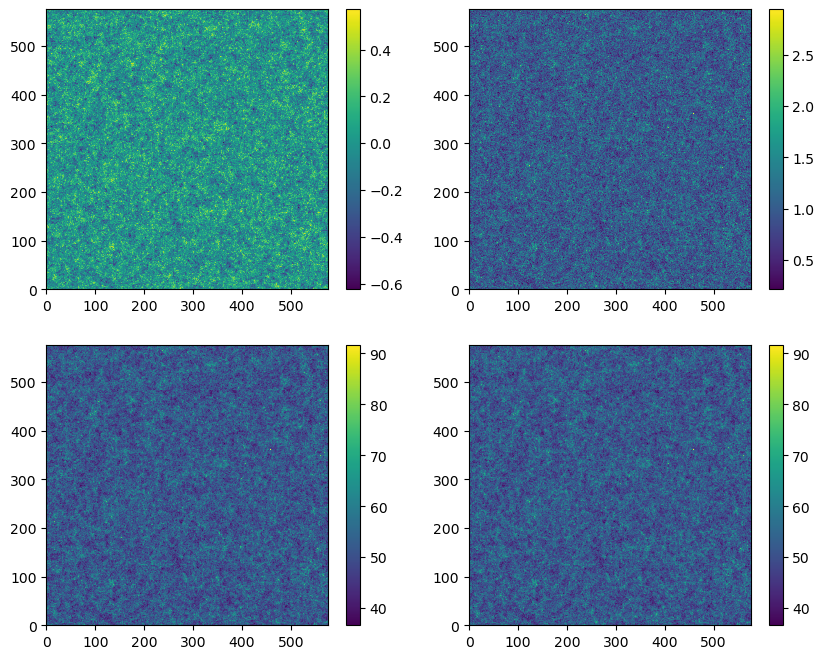

In [8]:
init_mesh0 = jnp.load(save_dir / f"init_mesh_{mesh_length}.npy")
tracer_mesh0 = jnp.load(save_dir / f"tracer_mesh_6746545_{mesh_length}.npy")
init_paint = jnp.load(save_dir / f"init_paint_{mesh_length}.npy")
fin_paint = jnp.load(save_dir / f"fin_paint_{mesh_length}.npy")
plt.figure(figsize=(10, 8))
plt.subplot(221)
plt.pcolormesh(init_mesh0.mean(2))
plt.colorbar()
plt.subplot(222)
plt.pcolormesh(tracer_mesh0.mean(2))
plt.colorbar()
plt.subplot(223)
plt.pcolormesh(fin_paint.mean(2))
plt.colorbar()
plt.subplot(224)
plt.pcolormesh(fin_paint.mean(2))
plt.colorbar()
plt.show()

In [ ]:
import plotly.express as px
idx = np.random.choice(positions.shape[0], size=10000, replace=False)
pos = positions[idx]

fig = px.scatter_3d(
    x=pos[:, 0],
    y=pos[:, 1],
    z=pos[:, 2],
    title="Random Sample of 10,000 Positions"
)
fig.update_traces(marker=dict(size=2))
fig.show()

In [19]:
from cosmoprimo.fiducial import AbacusSummit
cosmo = AbacusSummit(0)
pk_interpolator = cosmo.get_fourier().pk_interpolator().to_1d(z=0.)

n_interp = 256
ks = jnp.logspace(-4, 1, n_interp)
pows = pk_interpolator(ks) / cosmo.get_fourier().sigma8_m**2
init_kpow = jnp.stack((ks, pows))

np.save(load_dir / f'init_kpow.npy', init_kpow)
print("Omega_m:", cosmo['Omega_m'], "sigma8:", cosmo.get_fourier().sigma8_m)
cosmo.get_params('cosmology')

Omega_m: 0.3151917236644108 sigma8: 0.8076353990239834


{'h': array(0.6736),
 'Omega_cdm': array(0.26447041),
 'Omega_b': array(0.04930169),
 'Omega_k': 0.0,
 'sigma8': 0.8,
 'k_pivot': 0.05,
 'n_s': 0.9649,
 'alpha_s': 0.0,
 'beta_s': 0.0,
 'r': 0.0,
 'n_t': -0.0,
 'alpha_t': -0.0,
 'T_cmb': array(2.7255),
 'm_ncdm': array([0.05999992]),
 'neutrino_hierarchy': None,
 'T_ncdm_over_cmb': array([0.71611]),
 'N_eff': 3.044,
 'tau_reio': 0.0544,
 'reionization_width': 0.5,
 'A_L': 1.0,
 'w0_fld': array(-1.),
 'wa_fld': array(0.),
 'cs2_fld': array(1.),
 'H0': 0.7,
 'omega_cdm': 0.25,
 'Omega_c': 0.25,
 'omega_c': 0.25,
 'Omega_m': 0.25,
 'omega_m': 0.25,
 'Omega0_cdm': 0.25,
 'omch2': 0.25,
 'Omega0_m': 0.25,
 'omega_b': 0.05,
 'Omega0_b': 0.05,
 'ombh2': 0.05,
 'omega_k': 0.0,
 'Omega0_k': 0.0,
 'A_s': array(2.083e-09),
 'logA': 0.8,
 'ln10^10A_s': 0.8,
 'ln10^{10}A_s': 0.8,
 'ln_A_s_1e10': 0.8,
 'ns': 0.96,
 'nrun': 0.0,
 'nrunrun': 0.0,
 'Omega_g': 2.7255,
 'omega_g': 2.7255,
 'T0_cmb': 2.7255,
 'Omega0_g': 2.7255,
 'Omega_ncdm': None,
 'ome

## Validation

### Abacus meshes

In [ ]:
from montecosmo.utils import chreshape, r2chshape
def fourier_subsample(mesh0, mesh_length):
    mesh = jnp.fft.rfftn(mesh0)
    mesh = chreshape(mesh, r2chshape(3*(mesh_length,)))
    mesh = jnp.fft.irfftn(mesh)
    return mesh

# mesh0 = jnp.load(load_dir / f"init_mesh_{576}.npy")
# mesh0 = deconv_paint(mesh0, order=2)
mesh_lengths = [96]
for m in mesh_lengths:
    mesh = fourier_subsample(mesh0, m)
    save_path = load_dir / (f"init_mesh_{m}.npy")
    jnp.save(save_path, mesh)

mean_576: 1.000
mean_256: 1.000
mean_128: 1.000
mean_64: 1.000
mean_32: 1.000


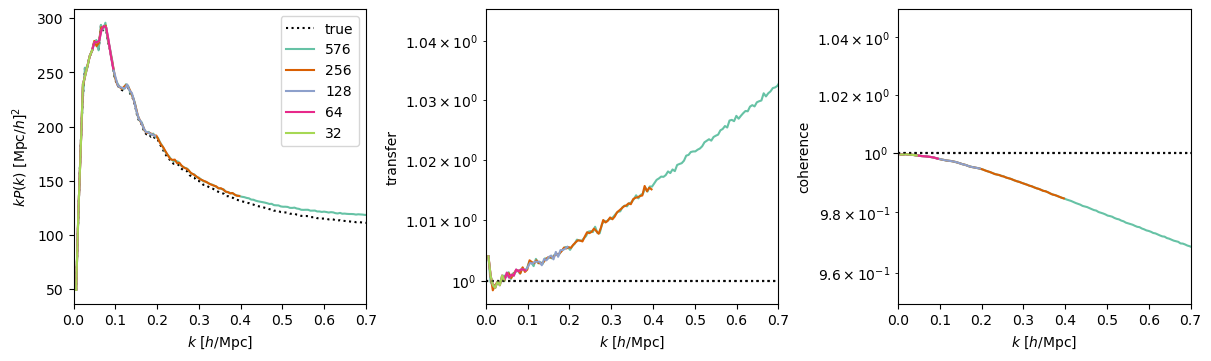

In [ ]:
from montecosmo.plot import plot_mesh, plot_pow, plot_powtranscoh, theme
from montecosmo.metrics import powtranscoh
from montecosmo.metrics import spectrum
from montecosmo.utils import chreshape, r2chshape
from matplotlib import colors
theme(usetex=False)
log = False
cmap = None
mesh_lengths = [576, 256, 128, 64, 32]
xlim = (0, .7)
box_size = np.array(3*(2000,))

def fourier_subsample(mesh0, mesh_length):
    mesh = jnp.fft.rfftn(mesh0)
    mesh = chreshape(mesh, r2chshape(3*(mesh_length,)))
    mesh = jnp.fft.irfftn(mesh)
    return mesh

plt.figure(figsize=(12, 3.5), layout="constrained")

for mesh_length in mesh_lengths:
    mesh0 = jnp.load(load_dir / f"fin_paint2_interl2_deconv1_{mesh_length}.npy")
    # mesh1 = jnp.load(load_dir / f"fin_paint_deconv_{mesh_length}.npy")
    noise = jr.normal(jr.key(45), 3*(576,))
    noise = fourier_subsample(noise, mesh_length)
    mesh1 = mesh0 + 0.5 * noise
    

    # TODO: add noise, that is fourier truncated
    print(f'mean_{mesh_length}: {mesh0.mean():.3f}')

    plt.subplot(131)
    plt.xlim(xlim)
    if mesh_length == mesh_lengths[0]:
        plot_pow(*spectrum(mesh0, box_size=box_size), 'k:', log=log, label="true")
    kptc1 = powtranscoh(mesh0, mesh1, box_size=box_size)
    plot_powtranscoh(*kptc1, log=log, label=mesh_length)
    plt.subplot(131)
    plt.legend()
    plt.subplot(132)
    plt.xlim(xlim)
    plt.axhline(1., linestyle=':', color='k', alpha=0.5)
    plt.subplot(133)
    plt.xlim(xlim)
    plt.ylim(.95,1.05)
    plt.axhline(1., linestyle=':', color='k', alpha=0.5);
# plt.savefig(f"./figs/abacus_matter_pow_interl2_deconv1_noise01.png")

mean_576: 1.000
mean_256: 1.000
mean_128: 1.000
mean_64: 1.000
mean_32: 1.000


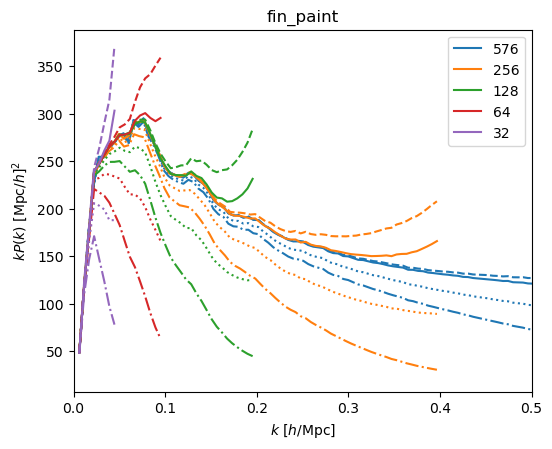

In [ ]:
from montecosmo.plot import plot_mesh, plot_pow, theme
from montecosmo.utils import chreshape, r2chshape
from montecosmo.metrics import spectrum
from montecosmo.bricks import AbacusSummit0
from montecosmo.nbody import deconv_paint
theme(cmap=None)

def fourier_subsample(mesh0, mesh_length):
    mesh = jnp.fft.rfftn(mesh0)
    mesh = chreshape(mesh, r2chshape(3*(mesh_length,)))
    mesh = jnp.fft.irfftn(mesh)
    return mesh

names = ["fin_paint"]
mesh_lengths = [576, 256, 128, 64, 32]
box_size = np.array(3*(2000,))
n_tracers = 6746545
cosmo = AbacusSummit0()
log = False

plt.figure(figsize=(10, 8), layout='constrained')
for i_plot, name in enumerate(names):
    plt.subplot(2,2,i_plot+1)
    plt.title(name)
    plt.xlim(0,0.5)

    if name == "init_mesh":
        init_kpow = jnp.load(load_dir / 'init_kpow.npy')
        init_kpow = (init_kpow[0], init_kpow[1] * cosmo.sigma8**2)
        plot_pow(*init_kpow, 'k+-', log=log, label="theory")

    for m in mesh_lengths:
        color = plt.gca()._get_lines.get_next_color()

        if name == "fin_paint":
            save_path = load_dir / (name + f"2_at_{m}.npy")
            mesh = jnp.load(save_path)
            mesh = deconv_paint(mesh, order=2)
            kpow = spectrum(mesh, box_size=box_size)
            plot_pow(*kpow, "-", log=log, color=color, label=f"{m}")
            print(f'mean_{m}: {mesh.mean():.3f}')

            save_path = load_dir / (name + f"1_at_{m}.npy")
            mesh = jnp.load(save_path)
            mesh = deconv_paint(mesh, order=1)
            kpow = spectrum(mesh, box_size=box_size)
            plot_pow(*kpow, "--", log=log, color=color)

            save_path = load_dir / (name + f"2_at_{m}.npy")
            mesh = jnp.load(save_path)
            # mesh = deconv_paint(mesh, order=2)
            kpow = spectrum(mesh, box_size=box_size)
            plot_pow(*kpow, "-.", log=log, color=color)

            save_path = load_dir / (name + f"1_at_{m}.npy")
            mesh = jnp.load(save_path)
            # mesh = deconv_paint(mesh, order=1)
            kpow = spectrum(mesh, box_size=box_size)
            plot_pow(*kpow, ":", log=log, color=color)

    plt.legend()
# plt.savefig(f"./figs/abacus_matter_pow_paint12_deconv01.png")      
# plt.show()

mean_576: -0.000
mean_256: -0.000
mean_128: -0.000
mean_64: -0.000
mean_32: -0.000

mean_576: 1.000
mean_256: 1.000
mean_128: 1.000
mean_64: 1.000
mean_32: 1.000

mean_576: 1.000
mean_256: 1.000
mean_128: 1.000
mean_64: 1.000
mean_32: 1.000

mean_576: 1.000
mean_256: 1.000
mean_128: 1.000
mean_64: 1.000
mean_32: 1.000



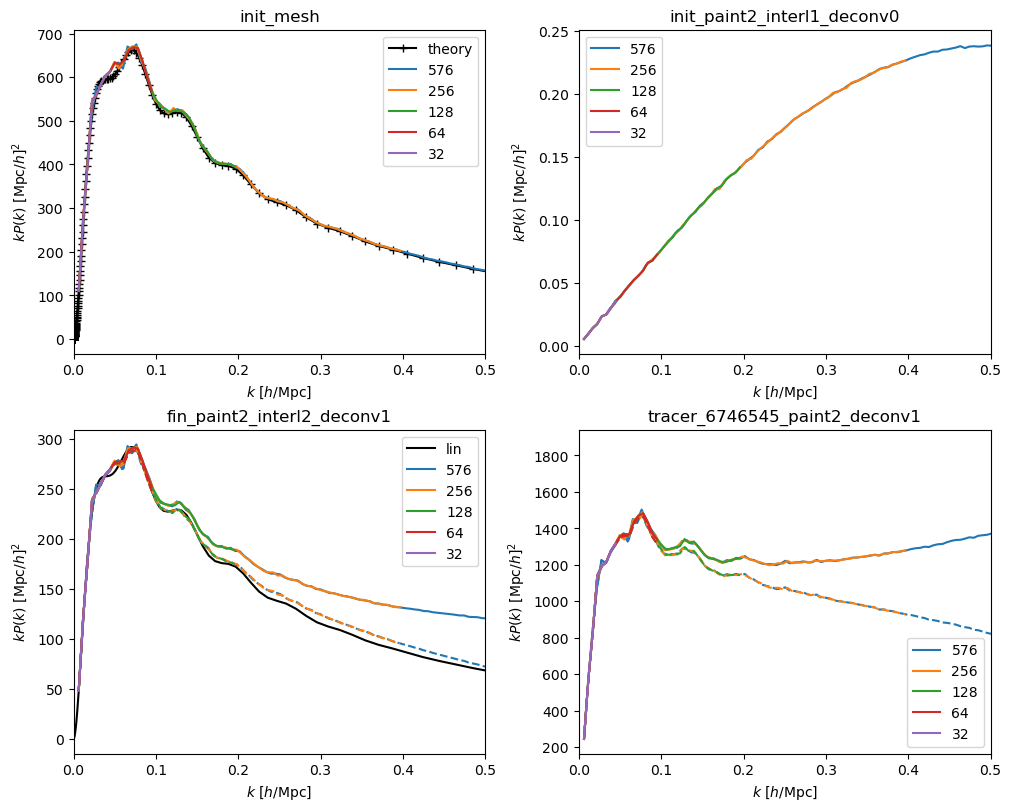

In [9]:
from montecosmo.plot import plot_mesh, plot_pow, theme
from montecosmo.utils import chreshape, r2chshape
from montecosmo.metrics import spectrum
from montecosmo.bricks import AbacusSummit0
from montecosmo.nbody import deconv_paint, a2g
theme(cmap=None)

def fourier_subsample(mesh0, mesh_length):
    mesh = jnp.fft.rfftn(mesh0)
    mesh = chreshape(mesh, r2chshape(3*(mesh_length,)))
    mesh = jnp.fft.irfftn(mesh)
    return mesh

names = ["init_mesh", "init_paint2_interl1_deconv0", "fin_paint2_interl2_deconv1", "tracer_6746545_paint2_deconv1"]
mesh_lengths = [576,256,128,64,32]
box_size = np.array(3*(2000,))
n_tracers = 6746545
cosmo = AbacusSummit0()
log = False
z_obs = 0.8

plt.figure(figsize=(10, 8), layout='constrained')
for i_plot, name in enumerate(names):
    plt.subplot(2,2,i_plot+1)
    plt.title(name)
    plt.xlim(0,0.5)

    # plot_mesh(mesh0)
    # plt.colorbar()

    if name == "init_mesh":
        init_kpow = jnp.load(load_dir / 'init_kpow.npy')
        init_kpow = (init_kpow[0], init_kpow[1] * cosmo.sigma8**2)
        plot_pow(*init_kpow, 'k+-', log=log, label="theory")

    if name == "fin_paint2_interl2_deconv1":
        init_kpow = jnp.load(load_dir / 'init_kpow.npy')
        init_kpow = (init_kpow[0], init_kpow[1] * cosmo.sigma8**2 * a2g(cosmo, 1/(1+z_obs))**2)
        plot_pow(*init_kpow, 'k-', log=log, label="lin")

    for m in mesh_lengths:
        color = plt.gca()._get_lines.get_next_color()
        save_path = load_dir / (name + f"_{m}.npy")
        mesh = jnp.load(save_path)
        kpow = spectrum(mesh, box_size=box_size)
        plot_pow(*kpow, log=log, label=f"{m}", color=color)
        print(f'mean_{m}: {mesh.mean():.3f}')

        if name == "fin_paint2_interl2_deconv1" or name == "tracer_6746545_paint2_deconv1":
            save_path = load_dir / (name.replace("deconv1", "deconv0") + f"_{m}.npy")
            mesh = jnp.load(save_path)
            kpow = spectrum(mesh, box_size=box_size)
            plot_pow(*kpow, "--", log=log, color=color)
    print()
    plt.legend()      
plt.show()

### Forward model

In [ ]:
from montecosmo.model import FieldLevelModel, default_config
from montecosmo.utils import pdump, pload , Path

box_size = 3*(2000,)
selection = None
mesh_length = 96
z_obs = 0.8

model = FieldLevelModel(**default_config | 
                        {'final_shape': 3*(mesh_length,), 
                        'cell_length': box_size[0] / mesh_length, # in Mpc/h
                        'box_center': (0.,0.,0.), # in Mpc/h
                        'box_rotvec': (0.,0.,0.,), # rotation vector in radians
                        'evolution': 'lpt',
                        'a_obs': 1 / (1 + z_obs), # light-cone if None
                        'curved_sky': False, # curved vs. flat sky
                        'ap_auto': None, # parametrized AP vs. auto AP
                        'selection': selection, # if float, padded fraction, if str or Path, path to window mesh file
                        'paint_order':2, # order of interpolation kernel
                        'kernel_type':'rectangular', # 'rectangular', 'kaiser_bessel'
                        'init_oversamp':1., # initial mesh 1D oversampling factor
                        'evol_oversamp':2., # evolution mesh 1D oversampling factor
                        'ptcl_oversamp':2., # particle cloud 1D oversampling factor
                        'paint_oversamp':2., # painted mesh 1D oversampling factor
                        # 'evol_oversamp':1., # evolution mesh 1D oversampling factor
                        # 'ptcl_oversamp':1., # particle cloud 1D oversampling factor
                        # 'paint_oversamp':1., # painted mesh 1D oversampling factor
                        'interlace_order':2, # interlacing order
                        'n_rbins': 1,
                        'k_cut': np.inf,
                        'init_power': load_dir / f'init_kpow.npy',
                        } )

print(model)
# model.render()

truth = {
    'Omega_m': 0.3137721, 
    'sigma8': 0.8076353990239834,
    # 'b1': 1.,
    'b1': 0.,
    'b2': 0.,
    'bs2': 0.,
    'bn2': 0.,
    'bnp': 0.,
    'fNL': 0.,
    'alpha_iso': 1.,
    'alpha_ap': 1.,
    # 'ngbars': 0.00084,
    'ngbars': 10000., # neglect shot noise
    }
init_mesh = jnp.fft.rfftn(jnp.load(load_dir / f'init_mesh_{576}.npy'))
init_mesh = chreshape(init_mesh, r2chshape(model.init_shape))
truth |= {'init_mesh': init_mesh}

# init_mesh = jnp.load(load_dir / f'init_mesh_{mesh_length}.npy')
# truth |= {'init_mesh': jnp.fft.rfftn(init_mesh)}
del init_mesh

# Abacus-truth
# obs_mesh = jnp.load(load_dir / f'fin_paint2_interl2_deconv0_{mesh_length}.npy')
obs_mesh = jnp.load(load_dir / f'fin_paint2_interl2_deconv1_{mesh_length}.npy')
# obs_mesh = jnp.load(load_dir / f'tracer_6746545_paint4_deconv1_{mesh_length}.npy')

# obs_mesh = deconv_paint(obs_mesh, order=2)
obs_mesh -= 1
# mean_count = truth['ngbars'] * model.cell_length**3
# if poisson:
#     obs_mesh = jr.poisson(jr.key(44), jnp.abs(obs_mesh + 1) * mean_count) / mean_count - 1
# else:
#     obs_mesh += jr.normal(jr.key(44), obs_mesh.shape) / mean_count**.5
truth0 = truth | {'obs': obs_mesh}
del obs_mesh

# Self-specified
truth1 = model.predict(samples=truth, hide_base=False, hide_samp=False, from_base=True)

model2 = FieldLevelModel(**model.asdict() | {
                                            # 'final_shape': 3*(256,),
                                            'init_oversamp':1.25,
                                            # 'evol_oversamp':2.,
                                            # 'ptcl_oversamp':2.,
                                            # 'paint_oversamp':2.,
                                            # 'kernel_type':'kaiser_bessel',
                                            # 'paint_order':4,
                                                })
init_mesh = jnp.fft.rfftn(jnp.load(load_dir / f'init_mesh_{576}.npy'))
init_mesh = chreshape(init_mesh, r2chshape(model2.init_shape))
truth |= {'init_mesh': init_mesh}
truth2 = model2.predict(samples=truth, hide_base=False, hide_samp=False, from_base=True)

model3 = FieldLevelModel(**model.asdict() | {
                                            # 'final_shape': 3*(128,),
                                            'init_oversamp':1.5,
                                            # 'evol_oversamp':2.,
                                            # 'ptcl_oversamp':2.,
                                            # 'paint_oversamp':2.,
                                            # 'kernel_type':'kaiser_bessel',
                                            # 'paint_order':2,
                                                })
init_mesh = jnp.fft.rfftn(jnp.load(load_dir / f'init_mesh_{576}.npy'))
init_mesh = chreshape(init_mesh, r2chshape(model3.init_shape))
truth |= {'init_mesh': init_mesh}
truth3 = model3.predict(samples=truth, hide_base=False, hide_samp=False, from_base=True)

# model4 = FieldLevelModel(**model.asdict() | {
#                                             'final_shape': 3*(128,),
#                                             'init_oversamp':1.,
#                                             'evol_oversamp':2.,
#                                             'ptcl_oversamp':2.,
#                                             'paint_oversamp':2.,
#                                             # 'kernel_type':'kaiser_bessel',
#                                             'paint_order':4,
#                                                 })
# init_mesh = jnp.fft.rfftn(jnp.load(load_dir / f'init_mesh_{576}.npy'))
# init_mesh = chreshape(init_mesh, r2chshape(model4.init_shape))
# truth |= {'init_mesh': init_mesh}
# truth4 = model4.predict(samples=truth, hide_base=False, hide_samp=False, from_base=True)

model.save(save_dir / "model.yaml")    
jnp.savez(save_dir / "truth.npz", **truth)
# delta_obs = model.count2delta(truth['obs'])
delta_obs0 = truth0['obs']
delta_obs1 = truth1['obs']
delta_obs2 = truth2['obs']
delta_obs3 = truth3['obs']
# delta_obs4 = truth4['obs']

# obs = ['obs','fNL','bnp','alpha_iso','alpha_ap','ngbars']
obs = ['obs','fNL','bnp','alpha_iso','alpha_ap','ngbars', 'init_mesh', 'sigma8', 'Omega_m']
# obs = ['obs','fNL','bnp','alpha_iso','alpha_ap','ngbars', 'init_mesh_']
# obs = ['obs','Omega_m','sigma8','fNL','b1','b2','bs2','bn2','bnp','alpha_iso','alpha_ap','ngbars']
# obs = ['obs','fNL','b1','b2','bs2','bn2','bnp','alpha_iso','alpha_ap','ngbars']
# obs = ['obs','fNL','alpha_iso','alpha_ap']
# obs = ['obs','fNL','bnp','alpha_iso','alpha_ap']
obs = {k: truth0[k] for k in obs}

model.condition(obs, from_base=True)
model.block()
# start_params = jit(vmap(partial(model.kaiser_post, delta_obs=delta_obs, scale_field=1/5)))(jr.split(jr.key(45), n_chains)) 
params_start = model.kaiser_post(jr.key(45), delta_obs0, scale_field=1/5)
print('start params:', params_start.keys())
# model.render()
potential_valgrad = jit(value_and_grad(model.potential))

# CONFIG
{'a_obs': 0.5555555555555556,
 'ap_auto': None,
 'box_center': array([0., 0., 0.]),
 'box_rotvec': array([0., 0., 0.]),
 'cell_length': 20.833333333333332,
 'curved_sky': False,
 'evol_oversamp': 2.0,
 'evolution': 'lpt',
 'final_shape': array([96, 96, 96]),
 'init_oversamp': 1.0,
 'init_power': '/pscratch/sd/h/hsimfroy/png/abacus_c0_i0_z08_lrg/load/init_kpow.npy',
 'interlace_order': 2,
 'k_cut': inf,
 'kernel_type': 'rectangular',
 'latents': {'Omega_m': {'group': 'cosmo',
                         'high': 1.0,
                         'label': '{\\Omega}_m',
                         'loc': 0.3111,
                         'loc_fid': 0.3111,
                         'low': 0.05,
                         'scale': 0.5,
                         'scale_fid': 0.01},
             'alpha_ap': {'group': 'ap',
                          'high': inf,
                          'label': '{\\alpha_\\mathrm{AP}}',
                          'loc': 1.0,
                          'loc_fid': 1.

prefix='m96_osamp2.0'


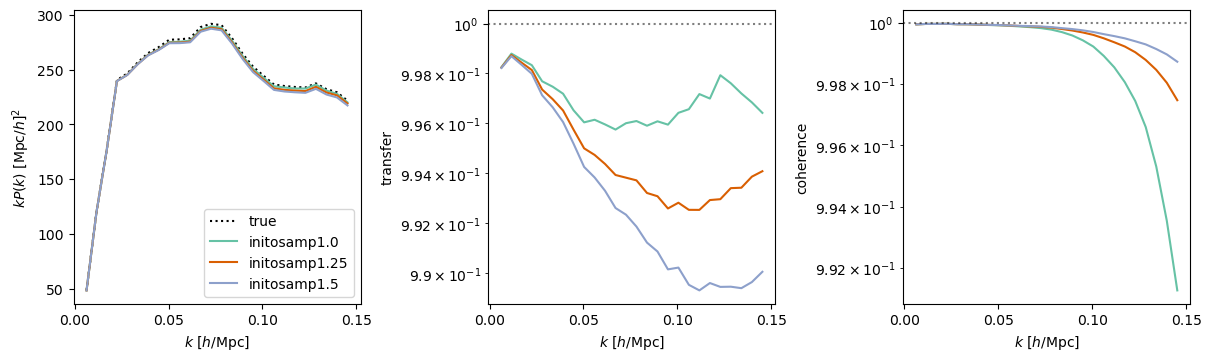

In [22]:
from montecosmo.plot import plot_mesh, plot_pow, plot_powtranscoh, theme
from matplotlib import colors
theme(usetex=False)
axis = 0
ids = .1
log = False
names = ["initosamp1.0", "initosamp1.25", "initosamp1.5"]
# names = ["osamp1.0", "osamp1.5", "osamp2.0"]
# prefix = f"m{model.final_shape[0]}_ktype{model.kernel_type}_paintorder{model.paint_order}_interl{model.interlace_order}"
prefix = f"m{model.final_shape[0]}_osamp2.0"
cmap = None
print(f"{prefix=}")

def plot_mesh2(masked):
    cmap = 'RdBu_r'
    quad = plot_mesh(model.masked2mesh(masked), box_size, ids, axis, cmap=cmap)
    clim = quad.get_clim()
    norm = colors.TwoSlopeNorm(0., *clim)
    quad = plot_mesh(model.masked2mesh(masked), box_size, ids, axis, cmap=cmap, vlim=None, norm=norm)

plt.figure(figsize=(12, 3.5), layout="constrained")

plt.subplot(131)
plot_pow(*model.spectrum(delta_obs0), 'k:', log=log, label="true")
kptc1 = model.powtranscoh(delta_obs0, delta_obs1)
plot_powtranscoh(*kptc1, log=log, label=names[0])
kptc2 = model.powtranscoh(delta_obs0, delta_obs2)
plot_powtranscoh(*kptc2, log=log, label=names[1])

# delta_obs0 = jnp.load(load_dir / f'fin_paint2_interl2_deconv1_{128}.npy')-1
kptc3 = model.powtranscoh(delta_obs0, delta_obs3)
plot_powtranscoh(*kptc3, log=log, label=names[2])
# kptc4 = model.powtranscoh(delta_obs0, delta_obs4)
# plot_powtranscoh(*kptc4, log=log, label=names[3])
plt.subplot(131)
plt.legend()
plt.subplot(132)
plt.axhline(1., linestyle=':', color='k', alpha=0.5)
plt.subplot(133)
plt.axhline(model.selec_mesh.mean(), linestyle=':', color='k', alpha=0.5);
plt.savefig(f"./figs/{prefix}_{"_".join(names)}_kptc.png")

### Fit EFT

In [ ]:
from jax.example_libraries.optimizers import adam
from tqdm import tqdm
lr0 = 1.
n_epochs = 100
energies = []

lr_fn = lambda i: lr0 / (1 + i)**.5
opt_init, opt_update, get_params = adam(lr_fn)
opt_state = opt_init(params_start)
# opt_state = opt_init(params)

def step(step, opt_state):
    value, pot_grad = potential_valgrad(get_params(opt_state))
    opt_state = opt_update(step, pot_grad, opt_state)
    return value, opt_state

for i_epoch in tqdm(range(n_epochs)):
    value, opt_state = step(i_epoch, opt_state)
    energies.append(float(value))
params = get_params(opt_state)
jnp.savez(save_dir / f'params_mode_{model.mesh_shape[0]}.npz', **params)

  0%|                                                                               | 0/500 [00:00<?, ?it/s]2025-11-05 05:38:18.580945: E external/xla/xla/service/slow_operation_alarm.cc:73] Constant folding an instruction is taking > 1s:

  %round-nearest-even.0 = f64[11239424,3]{1,0} round-nearest-even(f64[11239424,3]{1,0} %constant.11528), metadata={op_name="jit(potential)/jit(main)/jvp(jit(round))/round" source_file="/global/u1/h/hsimfroy/workspace/montecosmo_proj/src/montecosmo/montecosmo/nbody.py" source_line=256}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2025-11-05 05:38:38.313315: E external/xla/xla/service/slow_operation_ala

KeyboardInterrupt: 

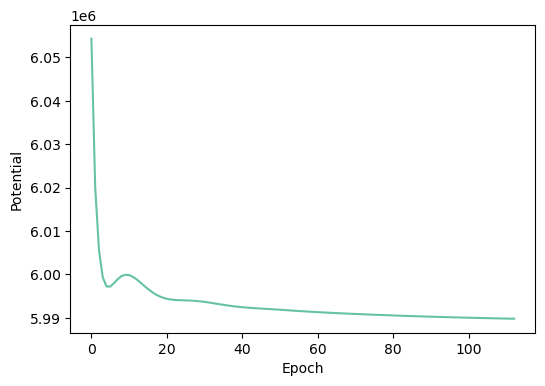

In [8]:
plt.figure(figsize=(6,4))
plt.plot(energies)
plt.xlabel("Epoch"), plt.ylabel("Potential")
plt.show()

In [3]:
model.reset()
params = dict(jnp.load(save_dir / f'params_mode_{model.mesh_shape[0]}.npz'))
print("Final params:\n", params, '\n', model.reparam(params))
truth1 = model.predict(samples=truth | params | {'ngbars':1000}, hide_base=False, hide_samp=False, from_base=True)
delta_obs1 = truth1['obs']

Final params:
 {'b1_': array(11.76061254), 'b2_': array(2.53433619), 'bn2_': array(0.69443178), 'bs2_': array(-3.26317035)} 
 {'b1': Array(1.11760613, dtype=float64), 'b2': Array(0.25343362, dtype=float64), 'bs2': Array(-0.32631704, dtype=float64), 'bn2': Array(0.69443178, dtype=float64)}


prefix='m128_cut0'


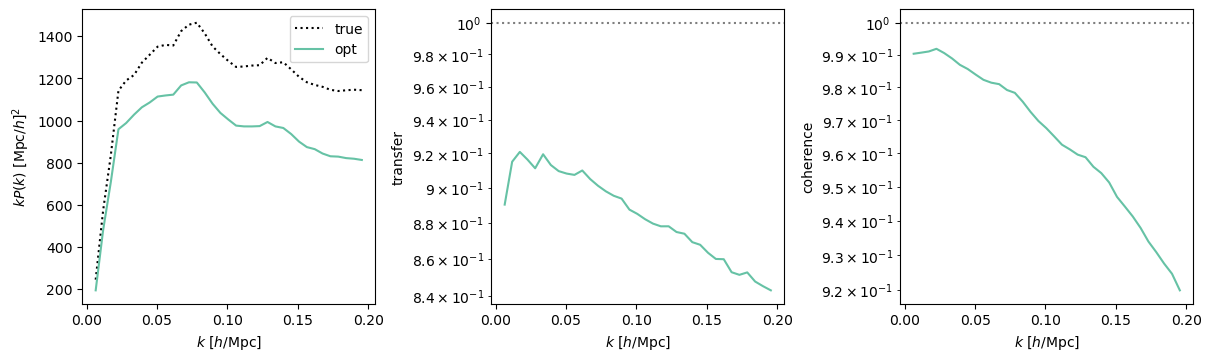

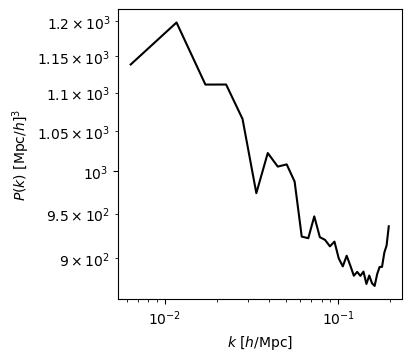

In [ ]:
from montecosmo.plot import plot_mesh, plot_pow, plot_powtranscoh, theme
from matplotlib import colors
theme(usetex=False)
axis = 0
ids = .1
names = ["opt"]
prefix = f"m{model.mesh_shape[0]}_cut{model.k_cut!=jnp.inf:d}"
cmap = None
print(f"{prefix=}")

def plot_mesh2(masked):
    cmap = 'RdBu_r'
    quad = plot_mesh(model.masked2mesh(masked), box_size, ids, axis, cmap=cmap)
    clim = quad.get_clim()
    norm = colors.TwoSlopeNorm(0., *clim)
    quad = plot_mesh(model.masked2mesh(masked), box_size, ids, axis, cmap=cmap, vlim=None, norm=norm)

# plt.figure(figsize=(13, 3.5), layout="constrained")
# plt.subplot(131)
# plt.title("true")
# plot_mesh(model.masked2mesh(truth['obs']), box_size, ids, axis, cmap=cmap)
# # plot_mesh2(truth['obs'])
# plt.colorbar()
# plt.subplot(132)
# plt.title(names[0])
# plot_mesh(model.masked2mesh(truth1['obs']), box_size, ids, axis, cmap=cmap)
# # plot_mesh2(truth1['obs'])
# plt.colorbar()
# plt.subplot(133)
# plt.title(names[1])
# plot_mesh(model.masked2mesh(truth2['obs']), box_size, ids, axis, cmap=cmap)
# # plot_mesh2(truth2['obs'])
# plt.colorbar()
# plt.savefig(f"./figs/{prefix}_{"_".join(names)}_mesh.png")


plt.figure(figsize=(12, 3.5), layout="constrained")
kptc1 = model.powtranscoh(delta_obs0, delta_obs1)
# kptc2 = model.powtranscoh(delta_obs0, delta_obs2)
# kptc3 = model.powtranscoh(delta_obs0, delta_obs3)

plt.subplot(131)
plot_pow(*model.spectrum(delta_obs0), 'k:', label="true")
plot_powtranscoh(*kptc1, label=names[0])
# plot_powtranscoh(*kptc2, label=names[1])
# plot_powtranscoh(*kptc3, label=names[2])
plt.subplot(131)
plt.legend()
plt.subplot(132)
plt.axhline(1., linestyle=':', color='k', alpha=0.5)
plt.subplot(133)
plt.axhline(model.selec_mesh.mean(), linestyle=':', color='k', alpha=0.5);
# plt.savefig(f"./figs/{prefix}_{"_".join(names)}_kptc.png")

plt.figure(figsize=(12, 3.5), layout="constrained")
noises = delta_obs0 - delta_obs1
print(noises.min(), noises.max(), noises.mean(), noises.std())
plt.subplot(131)
plt.hist(noises.ravel(), bins=100, density=True)
x = np.linspace(noises.min(), noises.max(), 200)
from scipy.stats import norm
pdf = norm.pdf(x, loc=noises.mean(), scale=noises.std())
plt.plot(x, pdf, label="Normal PDF")
plt.legend()
plt.subplot(132)
plot_pow(*model.spectrum(noises), 'k', log=True, label="noise")

## Lapprox

In [ ]:
from jax.example_libraries.optimizers import adam
from tqdm import tqdm
lr0 = 1.
n_epochs = 500
energies = []

lr_fn = lambda i: lr0 / (1 + i)**.5
opt_init, opt_update, get_params = adam(lr_fn)
opt_state = opt_init(params_start)
# opt_state = opt_init(params)

def step(step, opt_state):
    value, pot_grad = potential_valgrad(get_params(opt_state))
    opt_state = opt_update(step, pot_grad, opt_state)
    return value, opt_state

for i_epoch in tqdm(range(n_epochs)):
    value, opt_state = step(i_epoch, opt_state)
    energies.append(float(value))
params = get_params(opt_state)
jnp.savez(save_dir / f'params_mode_{model.mesh_shape[0]}.npz', **params)

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [01:08<00:00,  7.29it/s]


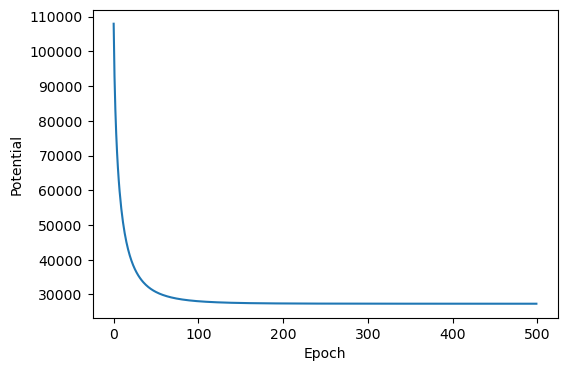

In [5]:
plt.figure(figsize=(6,4))
plt.plot(energies)
plt.xlabel("Epoch"), plt.ylabel("Potential")
plt.show()

Chains(data={'b2': Array(0.18354903, dtype=float64), 'b1': Array(1.2183641, dtype=float64), 'bn2': Array(-22.77584076, dtype=float64), 'bs2': Array(0.01984765, dtype=float64)}, groups={}, labels={})


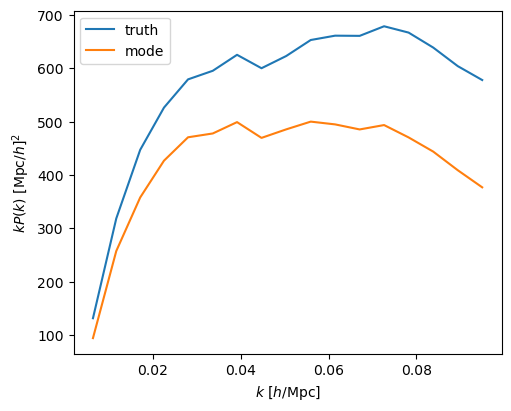

In [4]:
from montecosmo.chains import Chains
params = dict(jnp.load(save_dir / f'params_mode_{model.mesh_shape[0]}.npz'))
post_mode = Chains(model.reparam(params))
theta_mode, init_mode = post_mode[['*~init_mesh'],'init_mesh']
print(theta_mode)
plt.figure(figsize=(5, 4), layout="constrained")
plot_pow(*model.spectrum(truth['init_mesh']), label='truth')
plot_pow(*model.spectrum(init_mode), label='mode')
plt.legend();

In [ ]:
from montecosmo.chains import Chains
from montecosmo.lapprox import cov_x_from_pot_x_y

theta, mesh = Chains(params)[['*~init_mesh_'],['init_mesh_']]
(theta, unravel), (mesh, _) = theta.ravel(0), mesh.ravel(0)
names = list(unravel(theta).keys())
labels = [model.labels[k] for k in names]

def pot_fn(theta, mesh):
    params = unravel(theta) | {"init_mesh_": mesh}
    return model.potential(params.data)

cov_x, schur = cov_x_from_pot_x_y(pot_fn, theta, mesh, method='hutchinson', chunk_size=128)
jnp.save(save_dir / f'cov_mode_{model.mesh_shape[0]}.npy', cov_x)
jnp.save(save_dir / f'schur_mode_{model.mesh_shape[0]}.npy', schur)
print(jnp.linalg.eigvalsh(cov_x))

[-1.11442354e-03  7.03347360e-03  1.42559890e-02  7.91406757e+00]


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/getdist/gaussian_mixtures.py:39: RuntimeWarning: invalid value encountered in sqrt
  self.norms = (2 * np.pi) ** (0.5 * self.dim) * np.array([np.sqrt(np.linalg.det(cov)) for cov in self.covs])


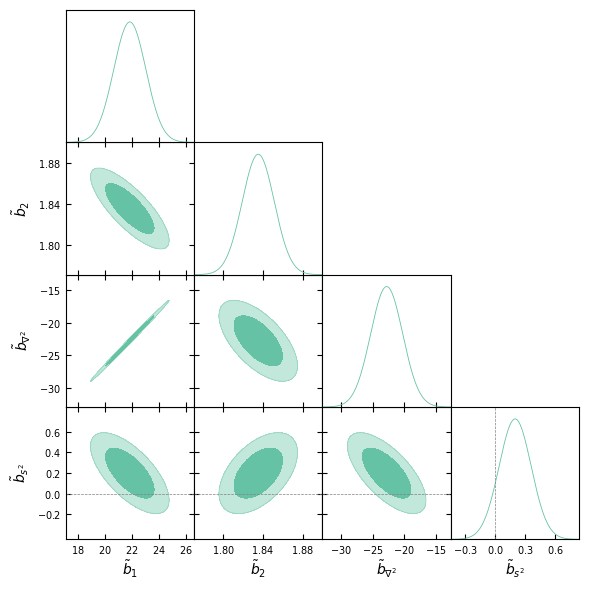

In [77]:
%matplotlib inline
from getdist import plots, gaussian_mixtures
from montecosmo.plot import SetDark2

gd_fisher = gaussian_mixtures.GaussianND(theta, cov_x, names=names, labels=labels, label='Full Lapprox')
g = plots.get_subplot_plotter(width_inch=6)
g.triangle_plot(gd_fisher, 
                filled=True, 
                contour_colors=[SetDark2(0)], 
                markers=truth)

In [ ]:
n_chains = 2
model.reset()
truth2 = model.predict(samples=(2,30), hide_base=True, hide_samp=True, from_base=True)

In [58]:
batch_ndim = 2
theta = Chains(truth2, model.groups_)[['*~init_mesh_','~init_mesh','~obs']]
out, unravel = theta.ravel(1)
print(theta.shape)
print(out.shape)
print(unravel(out).shape)

{'Omega_m_': (2, 30), 'alpha_ap_': (2, 30), 'alpha_iso_': (2, 30), 'b1_': (2, 30), 'b2_': (2, 30), 'bn2_': (2, 30), 'bnp_': (2, 30), 'bs2_': (2, 30), 'fNL_': (2, 30), 'ngbars_': (2, 30, 1), 'sigma8_': (2, 30)}
(2, 330)
{'Omega_m_': (2, 30), 'alpha_ap_': (2, 30), 'alpha_iso_': (2, 30), 'b1_': (2, 30), 'b2_': (2, 30), 'bn2_': (2, 30), 'bnp_': (2, 30), 'bs2_': (2, 30), 'fNL_': (2, 30), 'ngbars_': (2, 30, 1), 'sigma8_': (2, 30)}


Removed no burn in


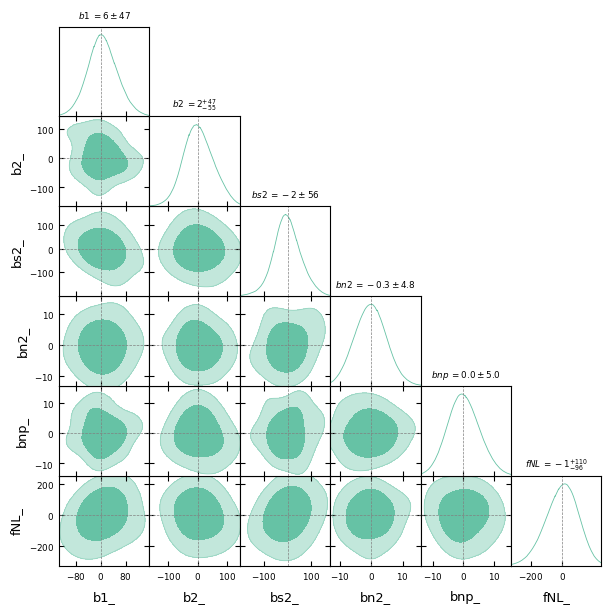

In [66]:
from getdist import plots
from montecosmo.plot import SetDark2
gdsamp = theta[['bias_']].to_getdist()
gdplt = plots.get_subplot_plotter(width_inch=7)
gdplt.triangle_plot(roots=[gdsamp],
                title_limit=1,
                filled=True, 
                markers=truth,
                contour_colors=[SetDark2(0)],)